## Define networks

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
import csv

class RNN(nn.Module):
    def __init__(self, input_dim=1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, 50, 1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        try:
            out, self.h = self.rnn(x, self.h)
        except Exception:
            self.h = Variable(torch.zeros(1, x.size(0), 50), requires_grad=False).cuda()
            out, self.h = self.rnn(x, self.h)
        self.h = Variable(self.h.data).cuda()
        out = F.relu(out[:, -1, :])
        out = self.fc(out)
        return out

class ANN(nn.Module):
    def __init__(self, input_size=100, bias=True):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size//2, bias=bias)
        self.fc2 = nn.Linear(input_size//2, 1, bias=bias)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        return out

class LSTM(nn.Module):
    def __init__(self, input_dim=1):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, 50, 1, dropout=0.2, batch_first=True)
        self.lstm2 = nn.LSTM(50, 100, 1, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(100, 1)
        
    def forward(self, x):
        try:
            out, self.h1 = self.lstm1(x, self.h1)
        except Exception:
            self.h1 = (Variable(torch.zeros(1, x.size(0), 50), requires_grad=False).cuda(),
                       Variable(torch.zeros(1, x.size(0), 50), requires_grad=False).cuda())
            out, self.h1 = self.lstm1(x, self.h1)
        self.h1 = (Variable(self.h1[0].data, requires_grad=False).cuda(),
                   Variable(self.h1[1].data, requires_grad=False).cuda())

        try:
            out, self.h2 = self.lstm2(out, self.h2)
        except Exception:
            self.h2 = (Variable(torch.zeros(1, x.size(0), 100), requires_grad=False).cuda(),
                       Variable(torch.zeros(1, x.size(0), 100), requires_grad=False).cuda())
            out, self.h2 = self.lstm2(out, self.h2)
        self.h2 = (Variable(self.h2[0].data, requires_grad=False).cuda(),
                   Variable(self.h2[1].data, requires_grad=False).cuda())
        out = F.relu(out[:, -1, :])
        out = self.fc(out)
        return out

## Prepare dataset

In [45]:
input_size = 2
file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h.csv','r'))
data = []
for row in file:
    if len(row[0]) == 16:
        data.append(float(row[5]))
        
# data_delta = []
# for i in range(len(data)-1):
#     data_delta.append(data[i+1]-data[i])
# data = data_delta

end_point = 4680
# data = (data - np.mean(data))/np.max(np.abs(data))
x = torch.Tensor(end_point - input_size, input_size)
y = torch.Tensor(end_point - input_size, 1)
for step in range(end_point - input_size):
    sequence = np.array(data[step : step + input_size + 1])
    sequence = (sequence - np.mean(sequence[:-1]))/np.max(np.abs(sequence[:-1]))
    x[step, :] = torch.from_numpy(sequence[:-1])
    y[step, :] = torch.FloatTensor([sequence[-1]])
train_set = torch.utils.data.TensorDataset(x, y)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

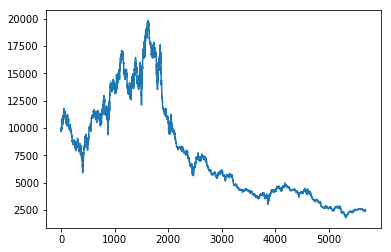

In [41]:
plt.plot(data)
plt.show()

## LSTM

In [4]:
input_dim = 1
model = LSTM(input_dim)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=10)
loss_func = nn.MSELoss()
epoch = 0
while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda().float()
        if input_dim == 1:
            inputs, targets = Variable(inputs).view(-1, inputs.size(1), 1), Variable(targets)
        else:
            inputs, targets = Variable(inputs).view(-1, 1, input_dim), Variable(targets)
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]
    train_loss /= len(train_loader)
    scheduler.step(train_loss)
    if epoch % 10 == 9:
        print('epoch: ', epoch + 1)
        print('loss: ', train_loss)
    epoch += 1

epoch:  10
loss:  0.00046986230331271683
epoch:  20
loss:  0.0004667968275277196
Epoch    29: reducing learning rate of group 0 to 1.0000e-02.
epoch:  30
loss:  0.0004698724967326868
epoch:  40
loss:  0.0004678699691352007
epoch:  50
loss:  0.00047151721239945774
Epoch    52: reducing learning rate of group 0 to 1.0000e-03.
epoch:  60
loss:  0.00047118060300252527
Epoch    63: reducing learning rate of group 0 to 1.0000e-04.
epoch:  70
loss:  0.0004668607513382527
Epoch    74: reducing learning rate of group 0 to 1.0000e-05.
epoch:  80
loss:  0.0004687519206011013
Epoch    85: reducing learning rate of group 0 to 1.0000e-06.


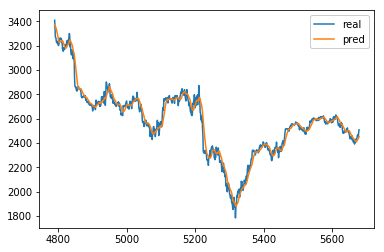

In [5]:
pred = []
error = []
start_point = 4780
test_data = data[start_point:]
for step in range(len(test_data)-input_size):
    seq = np.array(test_data[step : step+input_size+1])
    avg_seq = np.mean(seq)
    max_seq = np.max(np.abs(sequence))
    seq = (seq - avg_seq)/max_seq

    x_np = seq[:-1]
    y_np = seq[-1]

    if input_dim == 1:
        x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
    else:
        x = Variable(torch.from_numpy(x_np[np.newaxis, np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction = model(x)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(range(start_point+input_size, len(data)), test_data[input_size:], label='real')
plt.plot(range(start_point+input_size, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

In [6]:
np.mean([np.power(a-b, 2) for a, b in zip(test_data[input_size:], pred)])

2039.6774232366047

In [ ]:
plt.plot(test_data[-100:], label='real')
plt.plot(pred[-100:], label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

## RNN

In [4]:
input_dim = 1
model = RNN(input_dim)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=10)
loss_func = nn.MSELoss()
epoch = 0
while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda().float()
        if input_dim == 1:
            inputs, targets = Variable(inputs).view(-1, inputs.size(1), 1), Variable(targets)
        else:
            inputs, targets = Variable(inputs).view(-1, 1, input_dim), Variable(targets)
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]
    train_loss /= len(train_loader)
    scheduler.step(train_loss)
    if epoch % 10 == 9:
        print('epoch: ', epoch + 1)
        print('loss: ', train_loss)
    epoch += 1

epoch:  10
loss:  0.0004738110693398158
epoch:  20
loss:  0.0004666144912433181
epoch:  30
loss:  0.00046706323297946036
epoch:  40
loss:  0.000458038439565162
epoch:  50
loss:  0.0004559382056892925
epoch:  60
loss:  0.00044713439844624216
epoch:  70
loss:  0.0004438744335611527
epoch:  80
loss:  0.0004383129393367248
epoch:  90
loss:  0.0004366741868088374
epoch:  100
loss:  0.00043066762068396985
epoch:  110
loss:  0.000426532540980072
epoch:  120
loss:  0.00042141011107486447
epoch:  130
loss:  0.0004180226265767438
epoch:  140
loss:  0.00041496371409880956
epoch:  150
loss:  0.0004088169992649676
epoch:  160
loss:  0.00040533500833663384
epoch:  170
loss:  0.0004004628847453844
epoch:  180
loss:  0.0004010924682449046
epoch:  190
loss:  0.00039298013065048064
epoch:  200
loss:  0.0003897853068239685
epoch:  210
loss:  0.00038639822820629423
epoch:  220
loss:  0.0003785384980949095
epoch:  230
loss:  0.00037374719269447833
epoch:  240
loss:  0.00036900921219745904
epoch:  250
loss:

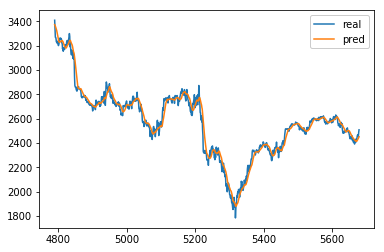

In [5]:
pred = []
error = []
start_point = 4780
test_data = data[start_point:]
for step in range(len(test_data)-input_size):
    seq = np.array(test_data[step : step+input_size+1])
    avg_seq = np.mean(seq)
    max_seq = np.max(np.abs(sequence))
    seq = (seq - avg_seq)/max_seq

    x_np = seq[:-1]
    y_np = seq[-1]

    if input_dim == 1:
        x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
    else:
        x = Variable(torch.from_numpy(x_np[np.newaxis, np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction = model(x)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(range(start_point+input_size, len(data)), test_data[input_size:], label='real')
plt.plot(range(start_point+input_size, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

In [6]:
np.mean([np.power(a-b, 2) for a, b in zip(test_data[input_size:], pred)])

2037.9903943562754

In [ ]:
plt.plot(test_data[-100:], label='real')
plt.plot(pred[-100:], label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

## ANN

In [43]:
input_size = 5
file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h.csv','r'))
data = []
for row in file:
    if len(row[0]) == 16:
        data.append(float(row[5]))

# data_delta = []
# for i in range(len(data)-1):
#     data_delta.append(data[i+1]-data[i])
# data = data_delta

end_point = 4680
# data = (data - np.mean(data))/np.max(np.abs(data))
x = torch.Tensor(end_point - input_size, input_size)
y = torch.Tensor(end_point - input_size, 1)
for step in range(end_point - input_size):
    sequence = np.array(data[step : step + input_size + 1])
    sequence = (sequence - np.mean(sequence[:-1]))
    x[step, :] = torch.from_numpy(sequence[:-1])
    y[step, :] = torch.FloatTensor([sequence[-1]])
max_seq = torch.max(x.abs())
x = x / max_seq
y = y / max_seq
train_set = torch.utils.data.TensorDataset(x, y)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

In [46]:
model = ANN(input_size)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=10)
loss_func = nn.MSELoss()
epoch = 0
while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda().float()
        inputs, targets = Variable(inputs).view(-1, inputs.size(1)), Variable(targets)
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]
    train_loss /= len(train_loader)
    scheduler.step(train_loss)
    if epoch % 10 == 9:
        print('epoch: ', epoch + 1)
        print('loss: ', train_loss)
    epoch += 1

epoch:  10
loss:  0.00023134447660964183
epoch:  20
loss:  0.00023119744720453446
Epoch    25: reducing learning rate of group 0 to 1.0000e-02.
epoch:  30
loss:  0.00023184944458645642
Epoch    36: reducing learning rate of group 0 to 1.0000e-03.
epoch:  40
loss:  0.00023164274170994759
Epoch    47: reducing learning rate of group 0 to 1.0000e-04.
epoch:  50
loss:  0.000231487445833753
Epoch    58: reducing learning rate of group 0 to 1.0000e-05.


In [53]:
sequence

array([-0.00160776,  0.00160776, -0.01449665])

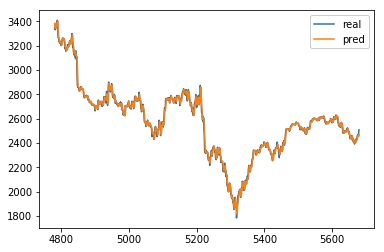

In [64]:
pred = []
error = []
start_point = 4780
test_data = data[start_point:]
for step in range(len(test_data)-input_size):
    seq = np.array(test_data[step : step+input_size+1])
    avg_seq = np.mean(seq[:-1])
    max_seq = np.max(np.abs(seq[:-1]))
    seq = (seq - avg_seq)/max_seq

    x_np = seq[:-1]
    y_np = seq[-1]
    x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction = model(x)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(range(start_point+input_size, len(data)), test_data[input_size:], label='real')
plt.plot(range(start_point+input_size, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

In [65]:
np.mean([np.power(a-b, 2) for a, b in zip(test_data[input_size:], pred)])

814.2675333884472

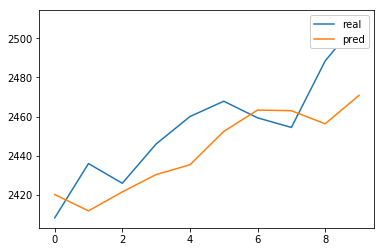

In [66]:
plt.plot(test_data[-10:], label='real')
plt.plot(pred[-10:], label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

In [ ]:
for input_size in [2, 3, 5, 10, 20, 30, 50, 70, 100]:
    print('\n==> input_length: ', input_size)
    file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h.csv','r'))
    data = []
    for row in file:
        if len(row[0]) == 16:
            data.append(float(row[5]))

    # data_delta = []
    # for i in range(len(data)-1):
    #     data_delta.append(data[i+1]-data[i])
    # data = data_delta

    end_point = 4680
    # data = (data - np.mean(data))/np.max(np.abs(data))
    x = torch.Tensor(end_point - input_size, input_size)
    y = torch.Tensor(end_point - input_size, 1)
    for step in range(end_point - input_size):
        sequence = np.array(data[step : step + input_size + 1])
        sequence = (sequence - np.mean(sequence[:-1]))
        x[step, :] = torch.from_numpy(sequence[:-1])
        y[step, :] = torch.FloatTensor([sequence[-1]])
    max_seq = torch.max(x.abs())
    x = x / max_seq
    y = y / max_seq
    train_set = torch.utils.data.TensorDataset(x, y)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
    model = ANN(input_size)
    model.cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False, patience=10)
    loss_func = nn.MSELoss()
    epoch = 0
    while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
        train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda().float()
            inputs, targets = Variable(inputs).view(-1, inputs.size(1)), Variable(targets)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data[0]
        train_loss /= len(train_loader)
        scheduler.step(train_loss)
        epoch += 1
    pred = []
    error = []
    start_point = 4780
    test_data = data[start_point:]
    for step in range(len(test_data)-input_size):
        seq = np.array(test_data[step : step+input_size+1])
        avg_seq = np.mean(seq[:-1])
        seq = (seq - avg_seq)/max_seq

        x_np = seq[:-1]
        y_np = seq[-1]
        x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
        y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

        prediction = model(x)

        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
        error.append(loss.cpu().data.sum())

    # plot prediction
    print('==> error: ', np.mean([np.power(a-b, 2) for a, b in zip(test_data[input_size:], pred)]))

In [ ]:
for input_size in [2, 3, 5, 10, 20, 30, 50, 70, 100]:
    print('\n==> input_length: ', input_size)
    file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h.csv','r'))
    data = []
    for row in file:
        if len(row[0]) == 16:
            data.append(float(row[5]))

    # data_delta = []
    # for i in range(len(data)-1):
    #     data_delta.append(data[i+1]-data[i])
    # data = data_delta

    end_point = 4680
    # data = (data - np.mean(data))/np.max(np.abs(data))
    x = torch.Tensor(end_point - input_size, input_size)
    y = torch.Tensor(end_point - input_size, 1)
    for step in range(end_point - input_size):
        sequence = np.array(data[step : step + input_size + 1])
        sequence = (sequence - np.mean(sequence[:-1]))
        x[step, :] = torch.from_numpy(sequence[:-1])
        y[step, :] = torch.FloatTensor([sequence[-1]])
    max_seq = torch.max(x.abs())
    x = x / max_seq
    y = y / max_seq
    train_set = torch.utils.data.TensorDataset(x, y)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
    
    model = LSTM(1)
    model.cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False, patience=10)
    loss_func = nn.MSELoss()
    epoch = 0
    while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
        train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda().float()
            inputs, targets = Variable(inputs).view(-1, inputs.size(1), 1), Variable(targets)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data[0]
        train_loss /= len(train_loader)
        scheduler.step(train_loss)
        epoch += 1

    pred = []
    error = []
    start_point = 4780
    test_data = data[start_point:]
    for step in range(len(test_data)-input_size):
        seq = np.array(test_data[step : step+input_size+1])
        avg_seq = np.mean(seq[:-1])
        seq = (seq - avg_seq)/max_seq

        x_np = seq[:-1]
        y_np = seq[-1]
        x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
        y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

        prediction = model(x)

        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
        error.append(loss.cpu().data.sum())

    # plot prediction
    print('==> error: ', np.mean([np.power(a-b, 2) for a, b in zip(test_data[input_size:], pred)]))


==> input_length:  2
==> error:  814.9420483636205

==> input_length:  3
==> error:  1022.3919019100089

==> input_length:  5
==> error:  1442.0212825697386

==> input_length:  10
==> error:  2399.7030853789283

==> input_length:  20
==> error:  789.8468275815933

==> input_length:  30
==> error:  910.480135150401

==> input_length:  50
==> error:  1112.137626326987

==> input_length:  70
==> error:  1066.9450354930536

==> input_length:  100


## Other experiments

epoch: 200
epoch: 400
epoch: 600
epoch: 800
epoch: 1000
epoch: 1200
epoch: 1400
epoch: 1600
epoch: 1800
epoch: 2000
epoch: 2200
epoch: 2400
epoch: 2600
epoch: 2800
epoch: 3000
epoch: 3200
epoch: 3400
epoch: 3600
epoch: 3800


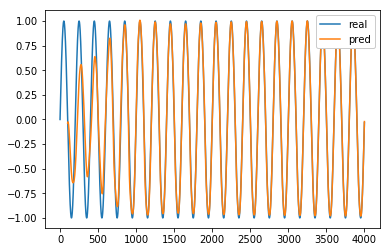

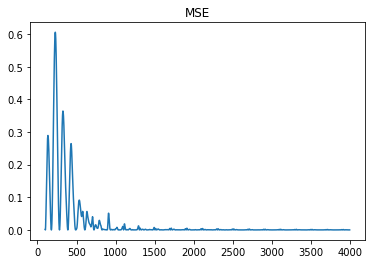

In [158]:
model = LSTM()
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

# data collection
data = np.arange(4000)
data = data * np.pi / 100
data = np.sin(data)

pred = []
error = []
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, np.newaxis, :])).float().cuda()
#     x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()
    prediction = model(x)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

# plot error
plt.plot(range(100, len(data)), error)
plt.title('MSE')
plt.show()

epoch: 200
epoch: 400
epoch: 600
epoch: 800


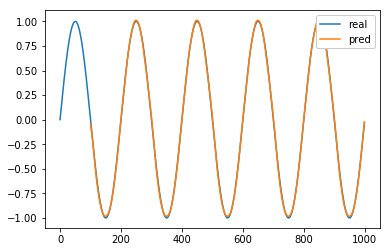

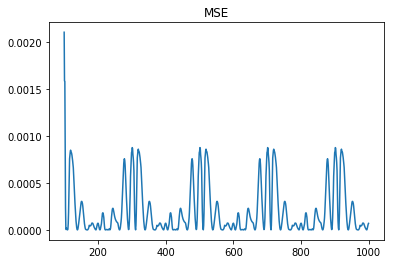

In [159]:
data = np.arange(1000)
data = data * np.pi / 100
data = np.sin(data)
model.eval()
pred = []
error = []
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, np.newaxis, :])).float().cuda()
#     x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()
    prediction = model(x)

    loss = loss_func(prediction, y)
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

# plot error
plt.plot(range(100, len(data)), error)
plt.title('MSE')
plt.show()

epoch: 200
epoch: 400
epoch: 600
epoch: 800


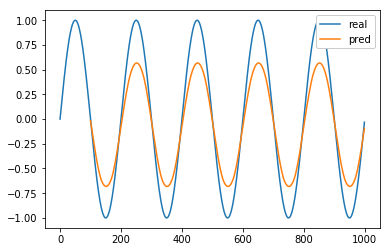

epoch: 200
epoch: 400
epoch: 600
epoch: 800


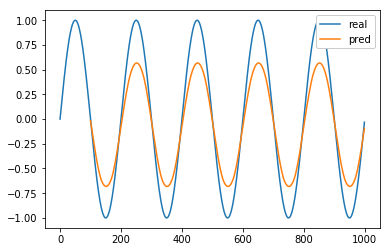

In [84]:
pred = []
data = data[0:1000]
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction, h_state = model(x, h_state)
    h_state = Variable(h_state.data)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
#     optimizer.step()
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

pred = []
data = data[0:1000]
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction, h_state = model(x, None)
    h_state = Variable(h_state.data)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
#     optimizer.step()
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

In [47]:
x = Variable(torch.Tensor(3,2,1)).cuda()

In [115]:
np.mean([x * np.power(max_value,2) for x in error[4000:]])

17538.790885794217

In [202]:
y


-1.4437e-10
 4.5602e-41
 6.7544e-04
     ⋮     
 0.0000e+00
 6.2078e-43
 0.0000e+00
[torch.FloatTensor of size 5580]

In [229]:
model = LSTM(1)
model.cuda()
for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs, volatile=True).view(-1, 100, 1), Variable(targets)
    outputs = model(inputs).view(-1)

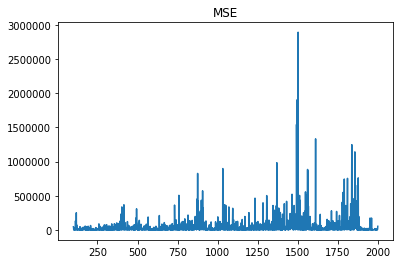

In [18]:
model = RNN()
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=2e-4)
loss_func = nn.MSELoss()

# data collection
import csv
file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h.csv','r'))
data = []
for row in file:
    if len(row[0]) == 16:
        data.append(float(row[5]))

h_state = None # initialize

length = 2000
pred = []
error2 = []
for step in range(length - 100):
    prediction = data[step + 99]
    y_np = data[step + 100]

    loss = pow(prediction - y_np, 2)
    error2.append(loss)

# # plot error
# plt.plot(range(100, length), [a_i - b_i for a_i, b_i in zip(error, error2)])
plt.plot(range(100, length), error2)
plt.title('MSE')
plt.show()

epoch: 200
epoch: 400
epoch: 600
epoch: 800
epoch: 1000
epoch: 1200
epoch: 1400
epoch: 1600
epoch: 1800


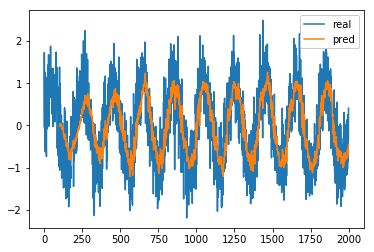

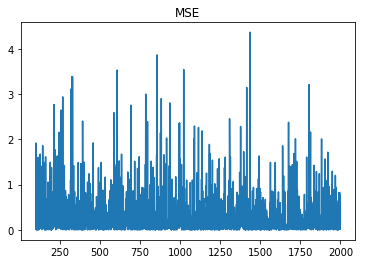

In [27]:

model = RNN()
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=2e-4)
loss_func = nn.MSELoss()

# data collection
data = np.arange(2000)
data = data * np.pi / 100
data = np.sin(data) + np.random.normal(0, 0.5, 2000)

h_state = None # initialization

pred = []
error = []
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction, h_state = model(x, h_state)
    h_state = Variable(h_state.data)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

# plot error
plt.plot(range(100, len(data)), error)
plt.title('MSE')
plt.show()